In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles



In [2]:
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)
print("Shape of X", X.shape)
print("Shape of y", y.shape)

Shape of X (1000, 2)
Shape of y (1000,)


In [3]:
type(X)

numpy.ndarray

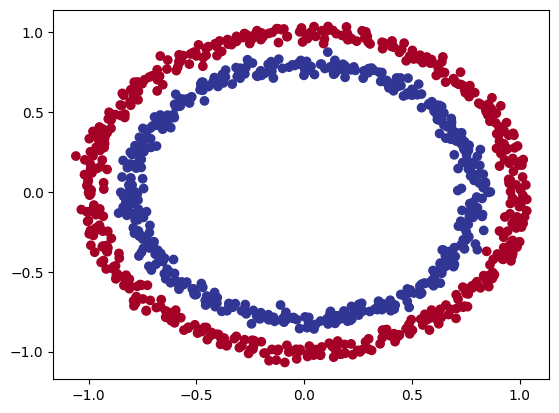

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdYlBu');

In [5]:
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
print("Type of X =", type(X))
print("Type of y =", type(y))

Type of X = <class 'torch.Tensor'>
Type of y = <class 'torch.Tensor'>


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

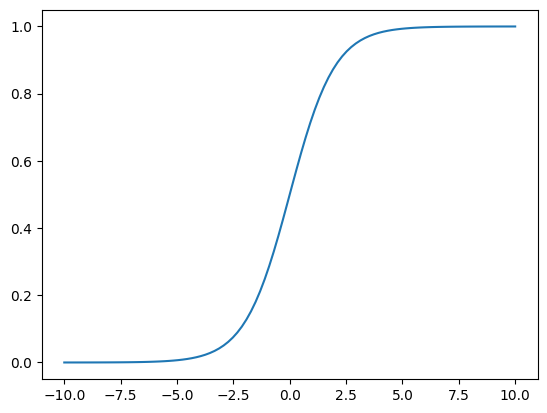

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

demo_x = np.linspace(-10,10,100)
demo_y = [sigmoid(val) for val in demo_x]
plt.plot(demo_x,demo_y)

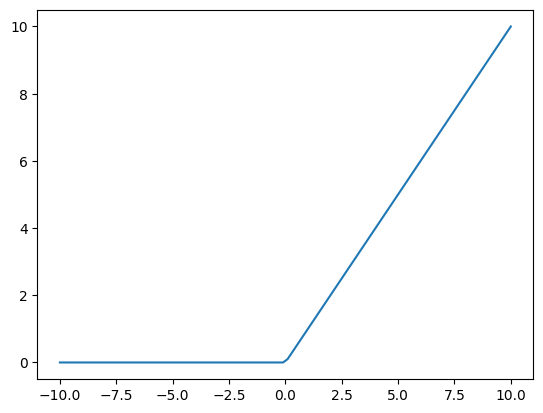

In [8]:
def relu(x):
    if x <= 0:
        return 0
    else:
        return x

demo_x = np.linspace(-10,10,100)
demo_y = [relu(val) for val in demo_x]
plt.plot(demo_x,demo_y)

In [9]:
class CircleClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_features=10):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features= hidden_features)
        self.layer_2 = nn.Linear(in_features=hidden_features, out_features= hidden_features)
        self.layer_3 = nn.Linear(in_features=hidden_features, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x:torch.tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [10]:
model_1 = CircleClassifier(input_features=2, output_features=1)
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4871, -0.1749],
                      [ 0.1470, -0.1987],
                      [ 0.1615,  0.0888],
                      [ 0.2329, -0.4468],
                      [ 0.6283, -0.6770],
                      [ 0.1207,  0.4403],
                      [-0.3371,  0.6470],
                      [ 0.6538, -0.5133],
                      [ 0.1660,  0.6165],
                      [-0.1239, -0.6001]])),
             ('layer_1.bias',
              tensor([-0.5406, -0.4365,  0.6337, -0.6319, -0.3220, -0.0241, -0.5369,  0.1165,
                      -0.6071,  0.6321])),
             ('layer_2.weight',
              tensor([[-0.1600,  0.0636,  0.1542,  0.0437, -0.1581, -0.2679, -0.0744, -0.2378,
                       -0.2736,  0.1834],
                      [ 0.0613, -0.0498, -0.2953,  0.0374, -0.1358, -0.2003,  0.2835,  0.2640,
                       -0.1412, -0.2265],
                      [ 0.0144, -0.0145,  0.2498, -0.3039,  0.2081, -0.2

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_1.parameters(), lr=0.01)

In [12]:
if torch.cuda.is_available():
    device='cuda'
elif torch.backends.mps.is_available():
    device=torch.device("mps")
else:
    device='cpu'
print(f"Using device = {device}")

Using device = mps


In [13]:
from sklearn.metrics import accuracy_score

In [14]:

epochs = 3000
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    ###Trading
    model_1.train()
    #1. Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    #2. Compute Loss
    loss = loss_fn(y_logits, y_train)

    #3. Zero grad optimizer resets all gradient befroe calculating new gradient
    optimizer.zero_grad()

    #4. Backpropagate
    loss.backward()

    #5. Step the optimer
    optimizer.step()
    acc=accuracy_score(y_true=y_train.cpu().detach().numpy(),y_pred=y_preds.cpu().detach().numpy())
    # testing
    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        acc=accuracy_score(y_true=y_train.cpu().detach().numpy(),y_pred=y_preds.cpu().detach().numpy())
    if (epoch%100==0):
        print(f"Epochs:{ epoch} Trains_loss { loss:.5f} test_loss {test_loss:.5f} test_accuracy{acc*100}")
    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epochs:0 Trains_loss 0.70355 test_loss 0.70163 test_accuracy50.0
Epochs:100 Trains_loss 0.69758 test_loss 0.69589 test_accuracy50.0
Epochs:200 Trains_loss 0.69462 test_loss 0.69290 test_accuracy50.0
Epochs:300 Trains_loss 0.69319 test_loss 0.69146 test_accuracy50.0
Epochs:400 Trains_loss 0.69238 test_loss 0.69066 test_accuracy64.25
Epochs:500 Trains_loss 0.69185 test_loss 0.69016 test_accuracy58.75
Epochs:600 Trains_loss 0.69145 test_loss 0.68980 test_accuracy55.875
Epochs:700 Trains_loss 0.69109 test_loss 0.68949 test_accuracy56.125
Epochs:800 Trains_loss 0.69077 test_loss 0.68917 test_accuracy55.125
Epochs:900 Trains_loss 0.69047 test_loss 0.68890 test_accuracy54.50000000000001
Epochs:1000 Trains_loss 0.69018 test_loss 0.68864 test_accuracy55.50000000000001
Epochs:1100 Trains_loss 0.68992 test_loss 0.68839 test_accuracy55.625
Epochs:1200 Trains_loss 0.68967 test_loss 0.68814 test_accuracy55.25
Epochs:1300 Trains_loss 0.68944 test_loss 0.68788 test_accuracy55.50000000000001
Epochs:140

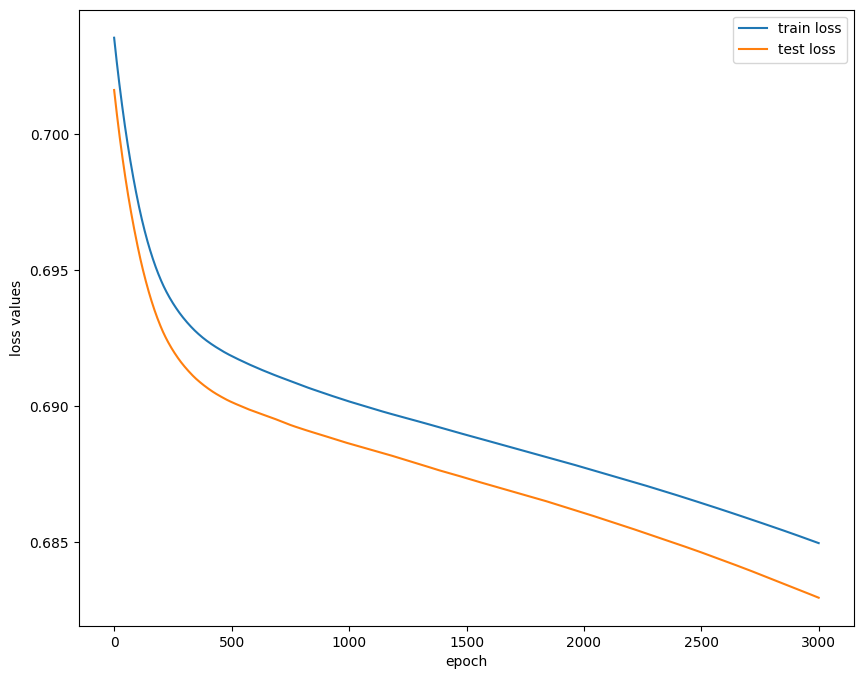

In [15]:
plt.figure(figsize=(10,8))
plt.plot(range(epochs),trainLossList,label="train loss")
plt.plot(range(epochs),testLossList,label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.legend()
